In [44]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/Dataset'

In [4]:
# base_dir = os.path.join(path , 'Rice Leaf Disease Images')

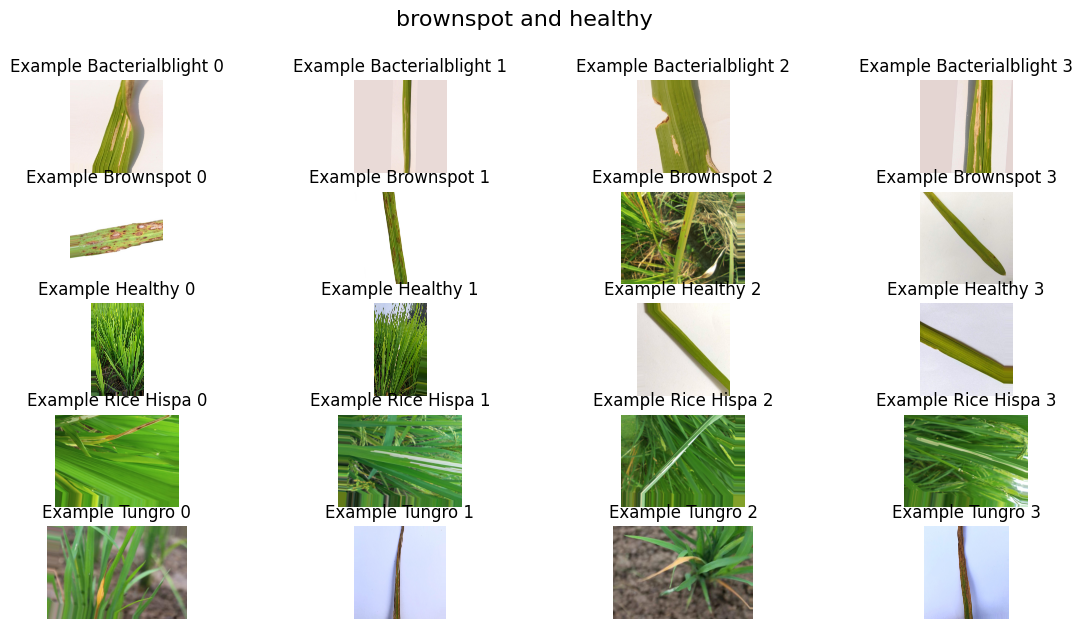

In [5]:
bacterialblight_filenames = [os.path.join(base_dir + '/train/bacterial_leaf_blight', filename) for filename in os.listdir(base_dir + '/train/bacterial_leaf_blight')]
brownspot_filenames = [os.path.join(base_dir + '/train/brown_spot', filename) for filename in os.listdir(base_dir + '/train/brown_spot')]
healthy_filenames = [os.path.join(base_dir + '/train/healthy', filename) for filename in os.listdir(base_dir + '/train/healthy')]
rice_hispa_filenames = [os.path.join(base_dir + '/train/rice_hispa', filename) for filename in os.listdir(base_dir + '/train/rice_hispa')]
tungro_filenames = [os.path.join(base_dir + '/train/tungro', filename) for filename in os.listdir(base_dir + '/train/tungro')]

fig, ax = plt.subplots(5, 4, figsize=(14, 7))
fig.suptitle('brownspot and healthy', fontsize=16)

for i, bacterialblight_image in enumerate(bacterialblight_filenames[:4]):
    img = tf.keras.utils.load_img(bacterialblight_image)
    ax[0, i].imshow(img)
    ax[0, i].set_title(f'Example Bacterialblight {i}')
    ax[0, i].axis('off')

for i, brownspot_image in enumerate(brownspot_filenames[:4]):
    img = tf.keras.utils.load_img(brownspot_image)
    ax[1, i].imshow(img)
    ax[1, i].set_title(f'Example Brownspot {i}')
    ax[1, i].axis('off')

for i, healthy_image in enumerate(healthy_filenames[:4]):
    img = tf.keras.utils.load_img(healthy_image)
    ax[2, i].imshow(img)
    ax[2, i].set_title(f'Example Healthy {i}')
    ax[2, i].axis('off')

for i, rice_hispa_image in enumerate(rice_hispa_filenames[:4]):
    img = tf.keras.utils.load_img(rice_hispa_image)
    ax[3, i].imshow(img)
    ax[3, i].set_title(f'Example Rice Hispa {i}')
    ax[3, i].axis('off')

for i, tungro_image in enumerate(tungro_filenames[:4]):
    img = tf.keras.utils.load_img(tungro_image)
    ax[4, i].imshow(img)
    ax[4, i].set_title(f'Example Tungro {i}')
    ax[4, i].axis('off')

plt.show()

# Create Training, Validation, and Test Dataset

In [6]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [7]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.15,
    subset="training",
    image_size=(224,224),
    label_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=None,
)

Found 7558 files belonging to 5 classes.
Using 6425 files for training.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.15,
    subset="validation",
    image_size=(224,224),
    label_mode='categorical',
    shuffle=False,
    seed=42,
    batch_size=None,
)

Found 7558 files belonging to 5 classes.
Using 1133 files for validation.


In [9]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    image_size=(224,224),
    label_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=None,
)

Found 1682 files belonging to 5 classes.


In [10]:
batch_size = 32

training_dataset = training_dataset.batch(batch_size, drop_remainder=True) \
                                    .shuffle(100) \
                                    .cache() \
                                    .prefetch(tf.data.AUTOTUNE)

validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True) \
                                        .cache() \
                                        .prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size, drop_remainder=True) \
                            .cache() \
                            .prefetch(tf.data.AUTOTUNE)

In [11]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (32, 224, 224, 3)
Shape of batch of labels: (32, 5)


# Augment Dataset

In [12]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
		    tf.keras.Input(shape=(224, 224,3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

    return augmentation_model

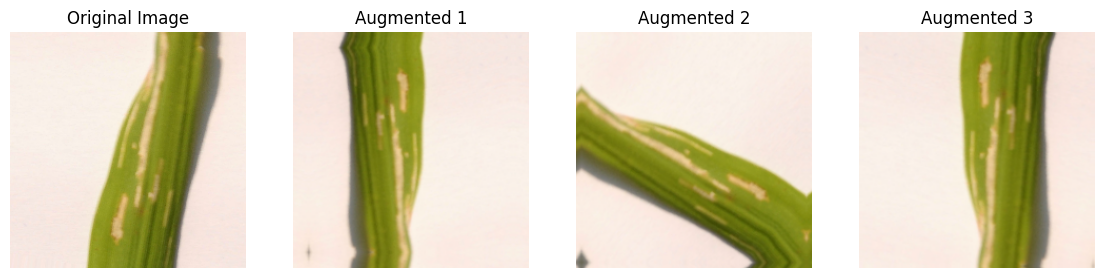

In [13]:
augmentation_layer = create_augmentation_model()

sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

for _ in range(3):
	image_aug = augmentation_layer(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# Create Model

In [54]:
# from tensorflow.keras.applications import VGG16

def create_model():
    # base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # for layer in base_model.layers:
    #     layer.trainable = False

    # model = tf.keras.Sequential([
    #     tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    #     tf.keras.layers.Rescaling(1./255),
    #     augmentation_layer,
    #     base_model,
    #     tf.keras.layers.GlobalAveragePooling2D(),
    #     tf.keras.layers.Dense(1024, activation='relu'),
    #     tf.keras.layers.Dropout(0.3),
    #     tf.keras.layers.Dense(5, activation='softmax')
    # ])

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        tf.keras.layers.Rescaling(1./255),
        # augmentation_layer,
        tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax'),
    ])


    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [55]:
model = create_model()

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,789 (932.77 KB)

 Trainable params: 238,789 (932.77 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.99):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if accuracy >= self.target_accuracy and val_accuracy >= self.target_accuracy:
            print(f"\nEpoch {epoch+1}: Stopping training as accuracy and validation accuracy both reached {self.target_accuracy}.")
            self.model.stop_training = True

In [57]:
history = model.fit(
    training_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    verbose=1,
    epochs=30,
    callbacks=[StopTrainingAtAccuracy()]
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4192 - loss: 1.3026 - val_accuracy: 0.8643 - val_loss: 0.4037
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7487 - loss: 0.6702 - val_accuracy: 0.6679 - val_loss: 1.2691
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8033 - loss: 0.5076 - val_accuracy: 0.8777 - val_loss: 0.3852
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8872 - loss: 0.3414 - val_accuracy: 0.9045 - val_loss: 0.3060
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8853 - loss: 0.3204 - val_accuracy: 0.9643 - val_loss: 0.1281
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9229 - loss: 0.2283 - val_accuracy: 0.9884 - val_loss: 0.0493
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9344 - loss: 0.1937 - val_accuracy: 0.9982 - val_loss: 0.0137
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9176 - loss: 0.2395 - val_acc

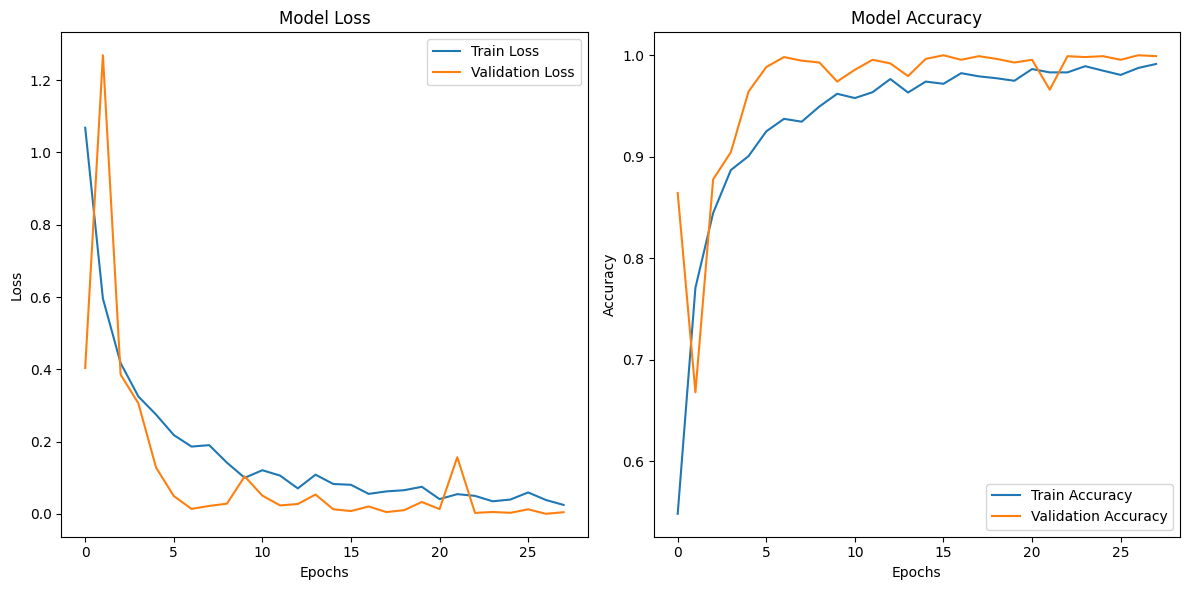

In [58]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predict Using the Model

In [59]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9858 - loss: 0.0624
Test Loss: 0.06019220128655434
Test Accuracy: 0.9831730723381042


In [60]:
class_names = sorted(os.listdir(train_dir))
print(class_names)

['bacterial_leaf_blight', 'brown_spot', 'healthy', 'rice_hispa', 'tungro']


In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


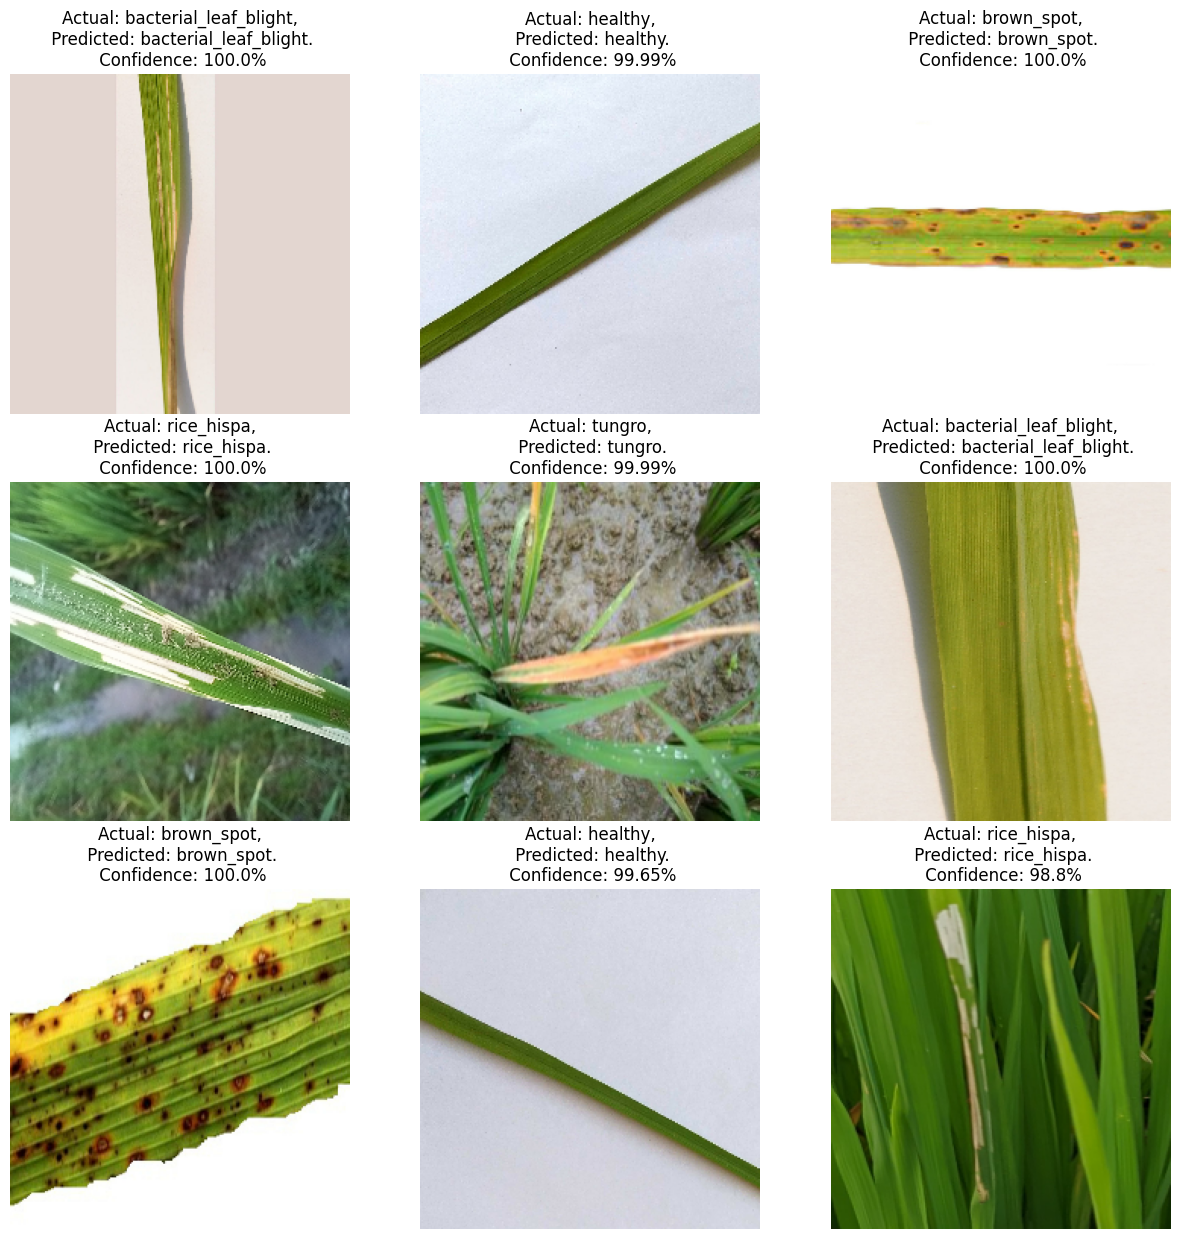

In [62]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())

        if len(labels.shape) > 1:
            label_index = tf.argmax(labels[i]).numpy()
        else:
            label_index = labels[i].numpy()

        actual_class = class_names[label_index]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [63]:
img_path='/content/R (1).jpg'

In [64]:
img = image.load_img(img_path, target_size=(256, 256))

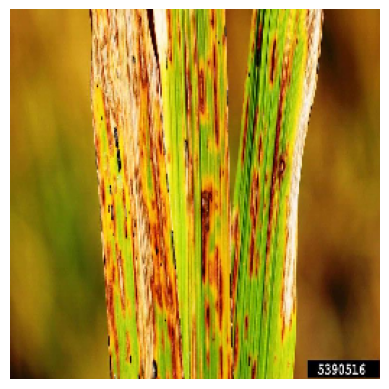

In [65]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [66]:
def predict_from_path(model, img_path, class_names, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions, axis=-1)[0]

    predicted_class = class_names[predicted_class_index]

    confidence = 100 * np.max(predictions)

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


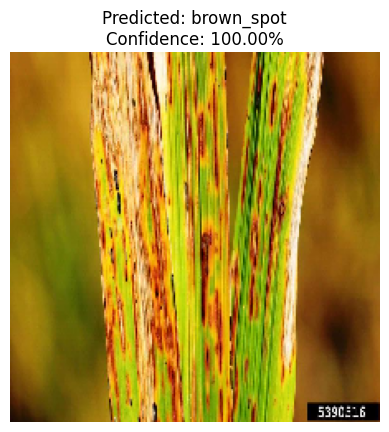

Predicted class: brown_spot, Confidence: 100.00%


In [67]:
predicted_class, confidence = predict_from_path(model, img_path, class_names)

print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}%")

# Save the Model

In [68]:
model.save('rice_leaf_model.keras')